<a href="https://colab.research.google.com/github/CodeKareMak/Machine-Learning-projects/blob/main/SolutionOfHeatEqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estimating epsilon using k=15, tolerance=1e-05...
  - Max k-th SqrDist (Cutoff^2): 0.0025
  - Estimated Epsilon: 0.0002
  - Equivalent Sigma: 0.0105

Calculating Kernel Matrix W...
Calculating Normalized Laplacian L_norm...
Solving eigenproblem using scipy.sparse.linalg.eigsh for 7 smallest eigenvalues...
SciPy solver finished.
SciPy Eigenvalues: [3.14602323e-10 7.21125471e-05 7.21125471e-05 2.88425510e-04
 2.88425510e-04 6.48868015e-04 6.48868015e-04]
SciPy Time: 2.16s

Starting SpectralNet training for 50 epochs...
Epoch 1/50, Loss: 0.051934, Time: 6.23s
Epoch 2/50, Loss: 0.021964, Time: 2.68s
Epoch 3/50, Loss: 0.013487, Time: 1.33s
Epoch 4/50, Loss: 0.012154, Time: 1.39s
Epoch 5/50, Loss: 0.009612, Time: 1.50s
Epoch 6/50, Loss: 0.008342, Time: 1.38s
Epoch 7/50, Loss: 0.006772, Time: 1.31s
Epoch 8/50, Loss: 0.005919, Time: 1.31s
Epoch 9/50, Loss: 0.006071, Time: 0.75s
Epoch 10/50, Loss: 0.006164, Time: 0.50s
Epoch 11/50, Loss: 0.006358, Time: 0.52s
Epoch 12/50, Loss: 0.006436, Time: 

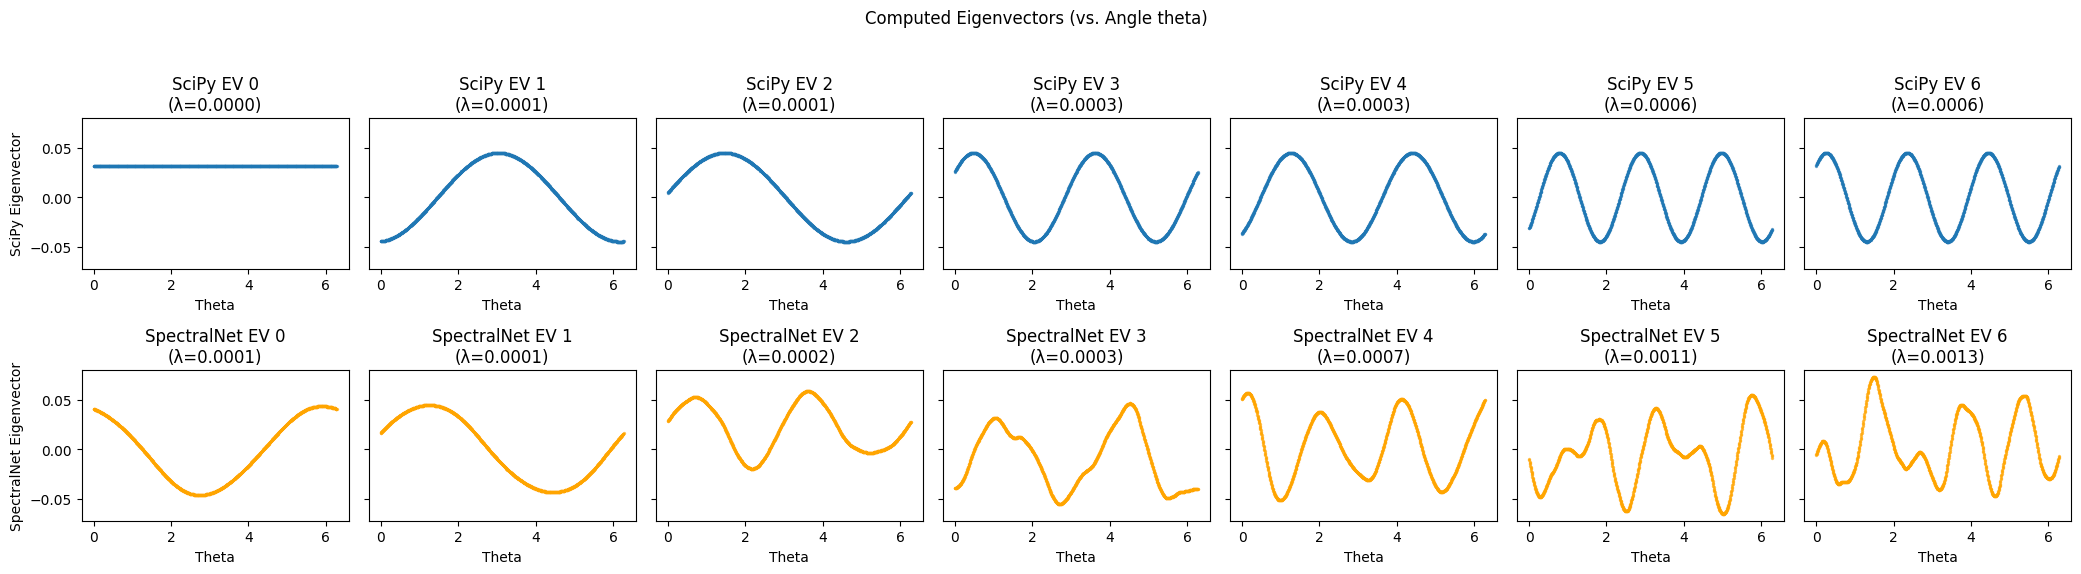


Simulating and Plotting Heat Equation Evolution...


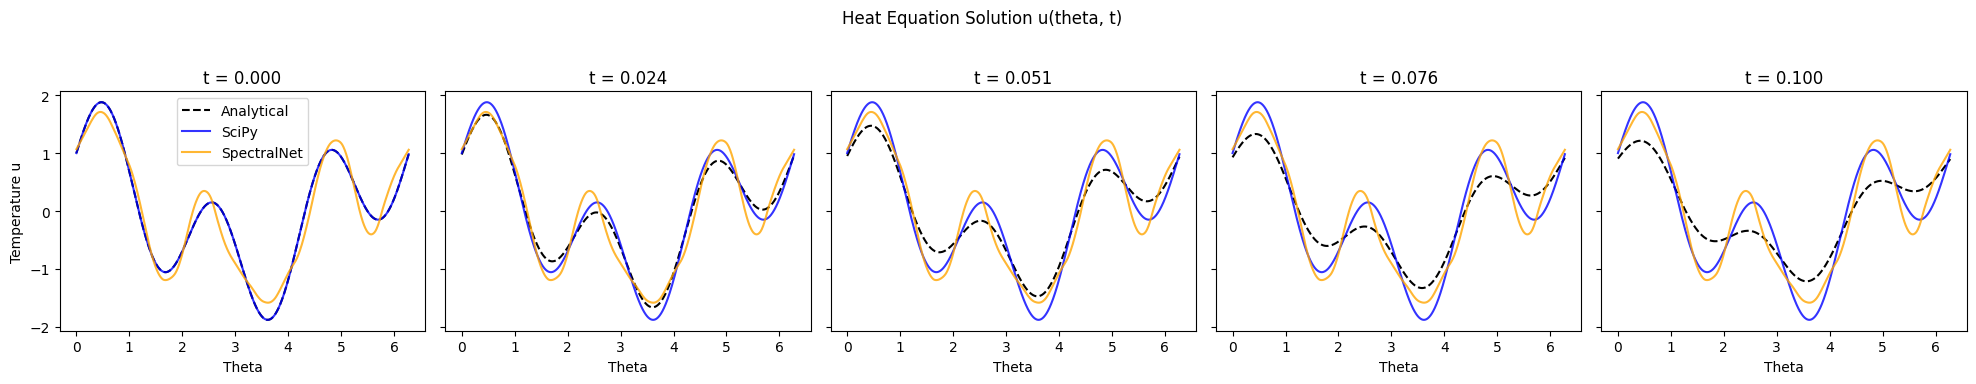

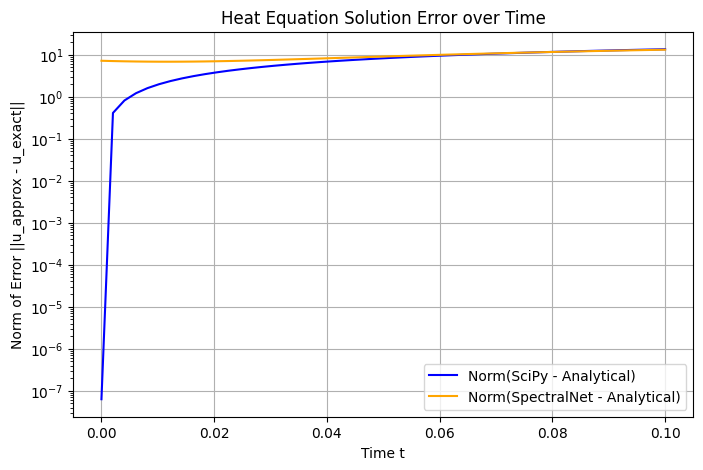


End-to-end script finished.


In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import lstsq
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import warnings

# Suppress verbose TensorFlow logging and potential divide-by-zero warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Configuration ---
N_POINTS = 1000       # Number of data points
N_EIGENVECTORS = 7   # Number of eigenvectors to compute (k)
NOISE_LEVEL = 0.0     # Optional noise for data generation
DOMAIN_RANGE = 2 * np.pi

# Kernel Parameters (Critically important!)
# We'll estimate epsilon using the kNN heuristic mentioned
KNN_FOR_EPSILON = 15
TOLERANCE_FOR_EPSILON = 1e-5 # Smaller tolerance -> larger epsilon -> broader kernel

# SpectralNet Hyperparameters
SN_EPOCHS = 50            # Reduced for faster demo
SN_BATCH_SIZE_GRAD = 128
SN_BATCH_SIZE_ORTHO = 256 # Usually larger or same as grad batch
SN_LEARNING_RATE = 1e-4
SN_ARCHITECTURE = [128, 64, 32] # Hidden layers
SN_PATIENCE = 10          # Early stopping patience (simplified check)

# Heat Equation Parameters
HEAT_T_MAX = 0.1       # Maximum time for heat equation simulation
HEAT_N_TIMES = 50      # Number of time steps to evaluate
HEAT_ALPHA = 1.0       # Diffusion coefficient (often implicitly 1)

# --- 1. Data Generation ---
def generate_circle_data(n_points, noise=0.0):
    """Generates points uniformly sampled on a circle."""
    thetas = np.linspace(0, DOMAIN_RANGE, n_points, endpoint=False)
    X = np.stack([np.cos(thetas), np.sin(thetas)], axis=1)
    if noise > 0:
        X += noise * np.random.randn(*X.shape)
    return X, thetas

# --- 2. Kernel & Laplacian ---
def estimate_epsilon(X, k, tolerance):
    """Estimate epsilon for Gaussian kernel using kNN distance heuristic."""
    print(f"Estimating epsilon using k={k}, tolerance={tolerance}...")
    pairwise_sq_dists = squareform(pdist(X, 'sqeuclidean'))
    # Sort distances for each point and get the k-th neighbor distance
    kth_distances = np.sort(pairwise_sq_dists, axis=1)[:, k]
    # Use the median of the k-th distances as the cutoff^2 heuristic
    # Or use the max as mentioned in thesis text for cutoff (more sensitive)
    # Let's use median for stability
    # cutoff_sq = np.median(kth_distances)
    # Use max as per Section 2.3 description (Cut off is max distance to k-th neighbor)
    cutoff_sq = np.max(kth_distances)
    if cutoff_sq < 1e-9:
         print("Warning: Cutoff distance very small, potential issues.")
         cutoff_sq = 1e-9 # Prevent log(0)
    epsilon = cutoff_sq / (-np.log(tolerance))
    print(f"  - Max k-th SqrDist (Cutoff^2): {cutoff_sq:.4f}")
    print(f"  - Estimated Epsilon: {epsilon:.4f}")
    # sigma = sqrt(epsilon / 2) for W = exp(-D^2 / (2*sigma^2)) = exp(-D^2/epsilon)
    sigma = np.sqrt(epsilon / 2.0)
    print(f"  - Equivalent Sigma: {sigma:.4f}")
    return epsilon, sigma

def gaussian_kernel_matrix(X, epsilon):
    """Computes the Gaussian kernel affinity matrix W."""
    pairwise_sq_dists = squareform(pdist(X, 'sqeuclidean'))
    W = np.exp(-pairwise_sq_dists / epsilon)
    np.fill_diagonal(W, 0) # Convention often sets diagonal to 0
    return sp.csr_matrix(W)

def normalized_laplacian(W):
    """Computes the normalized graph Laplacian L_norm = I - D^(-1/2) W D^(-1/2)."""
    N = W.shape[0]
    d = np.array(W.sum(axis=1)).flatten()
    d_inv_sqrt = 1.0 / np.sqrt(d + 1e-9) # Add epsilon for stability
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    L_norm = sp.identity(N, format='csr') - D_inv_sqrt @ W @ D_inv_sqrt
    return L_norm

# --- 3. Standard Solver (Datafold Simulation) ---
def solve_eig_scipy(L_norm, k):
    """Solves the eigenproblem using SciPy's eigsh."""
    print(f"Solving eigenproblem using scipy.sparse.linalg.eigsh for {k} smallest eigenvalues...")
    # We want smallest eigenvalues ('SM')
    # eigsh sorts them in ascending order by default for 'SM'
    eigenvalues, eigenvectors = eigsh(L_norm, k=k, which='SM', tol=1e-6)
    print("SciPy solver finished.")
    # Sort by eigenvalue magnitude (already done by 'SM', but good practice)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors

# --- 4. SpectralNet Implementation ---

class SpectralNetModel(keras.Model):
    def __init__(self, input_dim, k_eigenvectors, architecture, name="spectral_net", **kwargs):
        super().__init__(name=name, **kwargs)
        self.input_dim = input_dim
        self.k = k_eigenvectors
        self.architecture = architecture

        self.hidden_layers = []
        last_dim = input_dim
        for i, units in enumerate(architecture):
            self.hidden_layers.append(layers.Dense(units, activation='elu', name=f'hidden_{i}'))
            last_dim = units

        # Pre-orthogonalization output layer
        self.pre_ortho_layer = layers.Dense(self.k, activation=None, name='pre_ortho')

        # Final Orthogonalization 'Layer' - handled via weight setting in training loop
        # We define it here to hold the weights
        self.ortho_layer = layers.Dense(self.k, activation=None, use_bias=False, name='ortho_layer')
        # Build the layer to initialize weights, make it non-trainable by default gradient updates
        self.ortho_layer.build(input_shape=(None, self.k))
        self.ortho_layer.trainable = False # Managed manually

    def call(self, inputs, training=False, output_pre_ortho=False):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x, training=training)
        pre_ortho_output = self.pre_ortho_layer(x, training=training)

        if output_pre_ortho:
            return pre_ortho_output

        # Apply the manually set orthogonalization transform
        # Note: During inference, ortho_layer weights should be set appropriately (e.g., identity or final trained weights)
        # For training logic, the output needs to reflect the latest weights set in the train_step
        ortho_output = self.ortho_layer(pre_ortho_output)
        return ortho_output

    def set_ortho_weights(self, Y_tilde):
        """Calculates and sets weights for the ortho_layer based on input Y_tilde."""
        m = tf.shape(Y_tilde)[0]
        try:
            # Y^T Y = LL^T
            YTY = tf.matmul(Y_tilde, Y_tilde, transpose_a=True)
            # Add small identity matrix for numerical stability before Cholesky
            YTY += 1e-6 * tf.eye(tf.shape(YTY)[0])
            L = tf.linalg.cholesky(YTY)
            # Weights ~ (L^-1)^T * sqrt(m)
            L_inv_T = tf.transpose(tf.linalg.inv(L))
            weights = tf.sqrt(tf.cast(m, dtype=tf.float32)) * L_inv_T
            self.ortho_layer.set_weights([weights]) # Dense layer weights are a list containing one matrix
            return True
        except tf.errors.InvalidArgumentError as e:
            # Often happens if YTY is not positive definite due to numerical issues or rank deficiency
            print(f"Warning: Cholesky decomposition failed in set_ortho_weights: {e}. Skipping weight update.")
            # Optional: Set weights to identity or keep previous weights?
            # Setting to identity might disrupt learning progress. Let's skip update.
            # W_identity = tf.eye(self.k, dtype=tf.float32)
            # self.ortho_layer.set_weights([W_identity])
            return False


# Custom Training Loop Function
def train_spectralnet(model, dataset, W, D_inv_sqrt, L_norm_full, epochs, batch_size_grad, batch_size_ortho, learning_rate, patience):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate) # RMSProp also possible
    n_points = W.shape[0]
    best_loss = float('inf')
    wait = 0

    # Prepare TensorFlow datasets for batching
    # Ensure dataset is float32
    tf_dataset = tf.data.Dataset.from_tensor_slices(dataset.astype(np.float32))

    print(f"\nStarting SpectralNet training for {epochs} epochs...")
    for epoch in range(epochs):
        start_time = time.time()
        epoch_loss_avg = tf.keras.metrics.Mean()

        # --- Orthogonalization Step ---
        # Sample a batch for orthogonalization weight update
        ortho_batch_tf = tf_dataset.shuffle(n_points).batch(batch_size_ortho).take(1)
        for x_batch_ortho in ortho_batch_tf:
            # Get the output *before* the final ortho layer
            Y_tilde_ortho = model(x_batch_ortho, training=True, output_pre_ortho=True)
            # Set the weights of the final layer
            ortho_success = model.set_ortho_weights(Y_tilde_ortho)

        # --- Gradient Step ---
        # Iterate over gradient batches
        grad_batches_tf = tf_dataset.shuffle(n_points).batch(batch_size_grad)

        for x_batch_grad in grad_batches_tf:
            with tf.GradientTape() as tape:
                # Get the final output using the *current* ortho weights
                Y_batch = model(x_batch_grad, training=True, output_pre_ortho=False)

                # Calculate Loss: trace(Y^T L_norm Y)
                # Need L_norm for the *current batch* indices
                # This is complex. A common approximation uses W/D of the batch:
                # indices = # Need a way to get indices if using tf.Dataset
                # Let's use a simpler approximation or the full L_norm if batch size is large
                # Simplification: Assume loss correlates with full L_norm trace applied to batch outputs
                # OR compute W/D for the batch - requires original indices mapping back
                # Let's try the trace formulation with batch outputs: trace(Y_batch^T @ Y_batch) ? No.
                # Need trace(Y^T L Y). Let's use full L_norm - computationally heavy but conceptually closer.
                # NOTE: This is a deviation from pure mini-batch if using L_norm_full
                # A true mini-batch spectral clustering loss needs batch W and D.
                # For demonstration, let's use full L_norm applied to batch Y
                # Loss = trace(Y^T L_norm Y) approximation
                # If Y are columns, Y^T L Y has eigenvalues on diagonal approx
                # We need to compute L_norm_batch @ Y_batch efficiently
                # L_norm_full is sparse scipy matrix. Need to convert Y_batch to numpy?
                # --> This highlights a key difficulty in exact mini-batch spectral loss implementation.

                # Let's use a loss that *promotes* alignment with low-eigenvalue eigenvectors
                # Simplified Loss: Maximize variance along orthogonal axes? (Like PCA)
                # Let's stick to the Rayleigh quotient idea: Minimize Y^T L_norm Y
                # Use tf.sparse.sparse_dense_matmul if L_norm_full is converted to tf.SparseTensor
                # Convert necessary parts to TF tensors
                # This part is tricky and may need library support or careful sparse handling in TF

                # --- Alternative Simplified Loss (Inspired by paper, check reference [18, 27]) ---
                # They often use a pairwise loss on the batch:
                # Compute W_batch, D_batch from x_batch_grad
                batch_dists_sq = tf.reduce_sum(tf.square(x_batch_grad[:, None, :] - x_batch_grad[None, :, :]), axis=-1)
                # Need epsilon here - pass it as argument or make global
                # Assuming global `EPSILON` is defined
                W_batch = tf.exp(-batch_dists_sq / EPSILON)
                tf.linalg.set_diag(W_batch, tf.zeros(tf.shape(W_batch)[0])) # Diag=0
                D_batch_diag = tf.reduce_sum(W_batch, axis=1)
                D_inv_sqrt_batch_diag = 1.0 / tf.sqrt(D_batch_diag + 1e-9)

                # Pairwise loss term: Wij * || yi/sqrt(di) - yj/sqrt(dj) ||^2
                Y_norm = Y_batch * D_inv_sqrt_batch_diag[:, None] # yi / sqrt(di)
                # || yi/sqrt(di) - yj/sqrt(dj) ||^2 element-wise
                diff_sq = tf.reduce_sum(tf.square(Y_norm[:, None, :] - Y_norm[None, :, :]), axis=-1)
                loss_matrix = W_batch * diff_sq
                loss = tf.reduce_sum(loss_matrix) / (2.0 * tf.cast(tf.shape(x_batch_grad)[0], tf.float32)) # Normalize loss?


            # Compute gradients only for trainable layers (hidden + pre_ortho)
            trainable_vars = [var for layer in model.hidden_layers + [model.pre_ortho_layer] for var in layer.trainable_variables]
            gradients = tape.gradient(loss, trainable_vars)
            # Clip gradients if needed
            # gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients]
            optimizer.apply_gradients(zip(gradients, trainable_vars))
            epoch_loss_avg.update_state(loss)

        epoch_loss = epoch_loss_avg.result()
        elapsed_time = time.time() - start_time

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}, Time: {elapsed_time:.2f}s")

        # Simplified early stopping check
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            wait = 0
            # Optionally save best model weights
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

    print("SpectralNet training finished.")
    # After training, set the final ortho weights based on the full dataset's pre-ortho output
    print("Setting final orthogonalization weights based on full dataset...")
    Y_tilde_full = model(dataset.astype(np.float32), training=False, output_pre_ortho=True)
    model.set_ortho_weights(Y_tilde_full)
    print("Final weights set.")


def predict_spectralnet(model, dataset):
    """Predicts eigenvectors using the trained SpectralNet model."""
    print("Predicting eigenvectors using trained SpectralNet...")
    Y_pred_tf = model(dataset.astype(np.float32), training=False, output_pre_ortho=False)
    Y_pred = Y_pred_tf.numpy()
    # Normalize outputs to be unit vectors (important for consistency)
    Y_pred_norm = Y_pred / (np.linalg.norm(Y_pred, axis=0, keepdims=True) + 1e-9)
    print("Prediction finished.")
    return Y_pred_norm


# --- 5. Eigenvalue Calculation ---
def estimate_eigenvalues_spectralnet(Y, L_norm):
    """Estimate eigenvalues using computed eigenvectors Y and the Laplacian L_norm."""
    print("Estimating eigenvalues for SpectralNet results...")
    # Use Rayleigh quotient: lambda_k approx = y_k^T L_norm y_k (since y_k are normalized)
    eigenvalues_approx = np.diag(Y.T @ L_norm @ Y)
    # Sort them (important!)
    idx = np.argsort(eigenvalues_approx)
    eigenvalues_approx_sorted = eigenvalues_approx[idx]
    # Reorder eigenvectors accordingly
    Y_sorted = Y[:, idx]
    print("Eigenvalue estimation finished.")
    return eigenvalues_approx_sorted, Y_sorted


# --- 6. Heat Equation ---
# Initial condition g(theta)
def heat_initial_condition(thetas):
    # Example: sin(theta) + cos(2*theta) from thesis text
    # return np.sin(thetas) + np.cos(2 * thetas)
    # Example: sin(3*theta) + cos(theta) from thesis text
    return np.sin(3 * thetas) + np.cos(thetas)

# Analytical solution for the heat equation on a circle
def heat_analytical_solution(thetas, t, alpha, g0_func):
    """Computes the analytical solution using Fourier series."""
    # Calculate Fourier coefficients A0, Ak, Bk for g0_func(thetas)
    # Use numerical integration (e.g., trapezoidal rule) for coefficients
    n_points = len(thetas)
    dtheta = DOMAIN_RANGE / n_points

    # A0 = (1 / (2 * np.pi)) * np.trapz(g0_func(thetas), thetas) # More accurate integral
    A0 = (1 / n_points) * np.sum(g0_func(thetas)) # Approximation

    solution = np.full_like(thetas, A0)

    max_k = 50 # Use enough terms for reasonable accuracy
    for k in range(1, max_k + 1):
        cos_ktheta = np.cos(k * thetas)
        sin_ktheta = np.sin(k * thetas)

        # Ak = (1 / np.pi) * np.trapz(g0_func(thetas) * cos_ktheta, thetas)
        Ak = (2 / n_points) * np.sum(g0_func(thetas) * cos_ktheta)
        # Bk = (1 / np.pi) * np.trapz(g0_func(thetas) * sin_ktheta, thetas)
        Bk = (2 / n_points) * np.sum(g0_func(thetas) * sin_ktheta)

        decay_term = np.exp(-alpha * (k**2) * t)
        solution += decay_term * (Ak * cos_ktheta + Bk * sin_ktheta)

    return solution


# Numerical solution using computed eigenpairs
def heat_numerical_solution(thetas, t, alpha, eigenvalues, eigenvectors, g0):
    """Computes numerical solution using eigenpairs."""
    # Project initial condition onto eigenvectors: V c = g0 => c = V^+ g0
    # Use least squares: min || Vc - g0 ||^2
    V = eigenvectors # Eigenvectors are basis functions evaluated at thetas
    c, _, _, _ = lstsq(V, g0)

    # Evolve solution: u(t) = Sum_k c_k * exp(-lambda_k * alpha * t) * v_k
    solution = np.zeros_like(thetas)
    decay = np.exp(-eigenvalues * alpha * t)
    # Need to handle dimensions correctly: V @ (c * decay)
    solution = V @ (c * decay)
    return solution

# --- 7. Main Execution & Visualization ---
if __name__ == "__main__":
    # --- Setup ---
    X, thetas = generate_circle_data(N_POINTS, NOISE_LEVEL)
    g0 = heat_initial_condition(thetas) # Initial heat distribution

    # Estimate kernel parameter
    EPSILON, SIGMA = estimate_epsilon(X, KNN_FOR_EPSILON, TOLERANCE_FOR_EPSILON)

    # Calculate Kernel and Laplacian
    print("\nCalculating Kernel Matrix W...")
    W = gaussian_kernel_matrix(X, EPSILON)
    print("Calculating Normalized Laplacian L_norm...")
    L_norm = normalized_laplacian(W)
    # Need D_inv_sqrt for SpectralNet loss calc if using pairwise version
    d = np.array(W.sum(axis=1)).flatten()
    D_inv_sqrt_np = 1.0 / np.sqrt(d + 1e-9)

    # --- SciPy Solver ---
    t_start_scipy = time.time()
    eigvals_scipy, eigvecs_scipy = solve_eig_scipy(L_norm, N_EIGENVECTORS)
    t_end_scipy = time.time()
    print(f"SciPy Eigenvalues: {eigvals_scipy}")
    print(f"SciPy Time: {t_end_scipy - t_start_scipy:.2f}s")

    # --- SpectralNet Solver ---
    spectral_net = SpectralNetModel(input_dim=X.shape[1],
                                    k_eigenvectors=N_EIGENVECTORS,
                                    architecture=SN_ARCHITECTURE)
    t_start_sn_train = time.time()
    # Pass D_inv_sqrt if needed by the chosen loss implementation inside train_spectralnet
    train_spectralnet(spectral_net, X, W, D_inv_sqrt_np, L_norm,
                      SN_EPOCHS, SN_BATCH_SIZE_GRAD, SN_BATCH_SIZE_ORTHO,
                      SN_LEARNING_RATE, SN_PATIENCE)
    t_end_sn_train = time.time()

    t_start_sn_pred = time.time()
    eigvecs_sn_raw = predict_spectralnet(spectral_net, X)
    # Estimate eigenvalues and sort eigenvectors
    eigvals_sn, eigvecs_sn = estimate_eigenvalues_spectralnet(eigvecs_sn_raw, L_norm)
    t_end_sn_pred = time.time()

    print(f"\nSpectralNet Eigenvalues: {eigvals_sn}")
    print(f"SpectralNet Training Time: {t_end_sn_train - t_start_sn_train:.2f}s")
    print(f"SpectralNet Prediction+Eigenvalue Time: {t_end_sn_pred - t_start_sn_pred:.2f}s")


    # --- Visualization: Eigenvectors ---
    print("\nPlotting Eigenvectors...")
    fig, axes = plt.subplots(2, N_EIGENVECTORS, figsize=(N_EIGENVECTORS * 3, 6), sharey=True)
    fig.suptitle('Computed Eigenvectors (vs. Angle theta)')

    sort_idx_thetas = np.argsort(thetas) # Sort by angle for smooth plotting

    for i in range(N_EIGENVECTORS):
        # SciPy
        ax = axes[0, i]
        ax.scatter(thetas[sort_idx_thetas], eigvecs_scipy[sort_idx_thetas, i], s=2, alpha=0.6)
        ax.set_title(f'SciPy EV {i}\n(λ={eigvals_scipy[i]:.4f})')
        ax.set_xlabel('Theta')
        if i == 0: ax.set_ylabel('SciPy Eigenvector')

        # SpectralNet
        ax = axes[1, i]
        ax.scatter(thetas[sort_idx_thetas], eigvecs_sn[sort_idx_thetas, i], s=2, alpha=0.6, color='orange')
        ax.set_title(f'SpectralNet EV {i}\n(λ={eigvals_sn[i]:.4f})')
        ax.set_xlabel('Theta')
        if i == 0: ax.set_ylabel('SpectralNet Eigenvector')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
    plt.show()


    # --- Heat Equation Simulation & Visualization ---
    print("\nSimulating and Plotting Heat Equation Evolution...")
    times_to_plot = np.linspace(0, HEAT_T_MAX, HEAT_N_TIMES)

    # Choose specific time points for plotting profiles
    plot_indices = [0, HEAT_N_TIMES // 4, HEAT_N_TIMES // 2, 3 * HEAT_N_TIMES // 4, HEAT_N_TIMES - 1]
    plot_times = times_to_plot[plot_indices]

    fig_heat, axes_heat = plt.subplots(1, len(plot_times), figsize=(len(plot_times) * 4, 4), sharey=True)
    fig_heat.suptitle('Heat Equation Solution u(theta, t)')

    norm_diff_scipy = []
    norm_diff_sn = []

    for idx, t in enumerate(times_to_plot):
        u_analytical = heat_analytical_solution(thetas, t, HEAT_ALPHA, heat_initial_condition)
        u_scipy = heat_numerical_solution(thetas, t, HEAT_ALPHA, eigvals_scipy, eigvecs_scipy, g0)
        u_sn = heat_numerical_solution(thetas, t, HEAT_ALPHA, eigvals_sn, eigvecs_sn, g0)

        norm_diff_scipy.append(np.linalg.norm(u_scipy - u_analytical))
        norm_diff_sn.append(np.linalg.norm(u_sn - u_analytical))

        if idx in plot_indices:
            ax_idx = plot_indices.index(idx)
            ax = axes_heat[ax_idx]
            ax.plot(thetas[sort_idx_thetas], u_analytical[sort_idx_thetas], label='Analytical', color='k', linestyle='--')
            ax.plot(thetas[sort_idx_thetas], u_scipy[sort_idx_thetas], label=f'SciPy', color='blue', alpha=0.8)
            ax.plot(thetas[sort_idx_thetas], u_sn[sort_idx_thetas], label=f'SpectralNet', color='orange', alpha=0.8)
            ax.set_title(f't = {t:.3f}')
            ax.set_xlabel('Theta')
            if ax_idx == 0:
                ax.set_ylabel('Temperature u')
                ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Plot Norm of Error over Time
    plt.figure(figsize=(8, 5))
    plt.plot(times_to_plot, norm_diff_scipy, label='Norm(SciPy - Analytical)', color='blue')
    plt.plot(times_to_plot, norm_diff_sn, label='Norm(SpectralNet - Analytical)', color='orange')
    plt.xlabel('Time t')
    plt.ylabel('Norm of Error ||u_approx - u_exact||')
    plt.title('Heat Equation Solution Error over Time')
    plt.legend()
    plt.grid(True)
    plt.yscale('log') # Often useful to see behavior
    plt.show()

    print("\nEnd-to-end script finished.")